In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, plot_elbo, plot_gps_components, model_graph
from libs.model import HGPforecaster
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import json

import theano
theano.config.compute_test_value='raise'

/home/mach1ne/anaconda3/envs/phd_clean/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
# Read in the data
INPUT_DIR = 'm5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [4]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [5]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


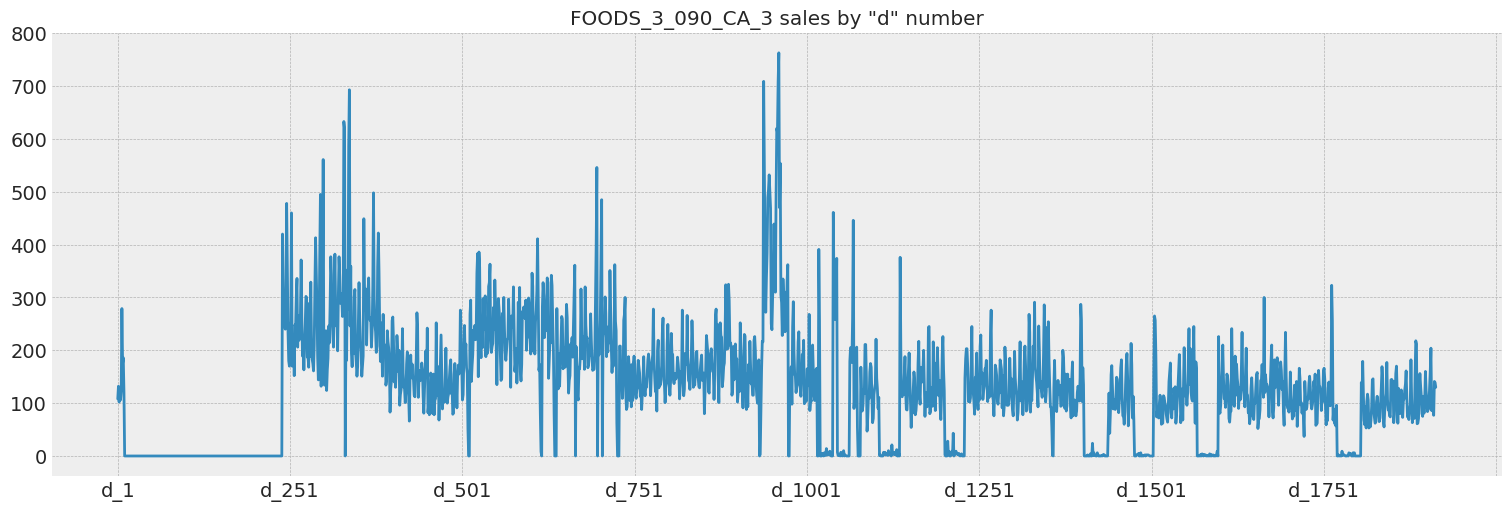

In [6]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

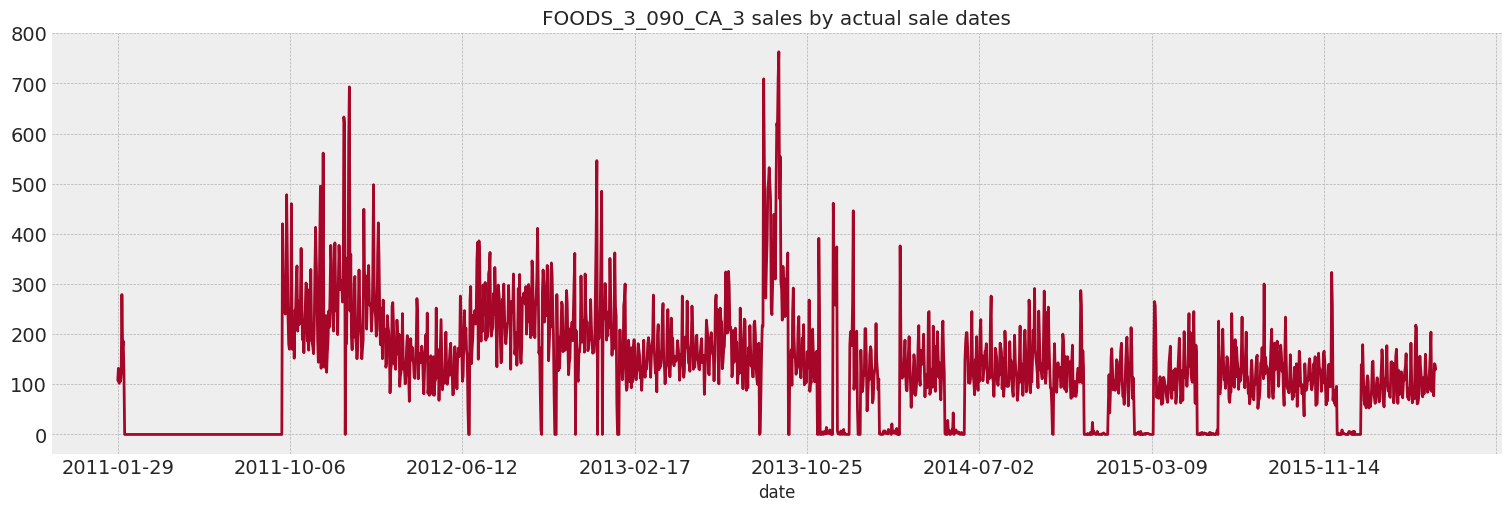

In [7]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [8]:
stv.columns[:6]

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [9]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [10]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [11]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [12]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [13]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [14]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

dept_id             object
cat_id              object
store_id            object
state_id            object
day                 object
value                int64
Date        datetime64[ns]
dtype: object

In [15]:
# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

In [16]:
stv_weekly

dept_id      cat_id     store_id  state_id  Date      
FOODS_1      FOODS      CA_1      CA        2011-01-30     473
                                            2011-02-06    2014
                                            2011-02-13    1755
                                            2011-02-20    1599
                                            2011-02-27    1589
                                                          ... 
HOUSEHOLD_2  HOUSEHOLD  WI_3      WI        2016-03-27     620
                                            2016-04-03     669
                                            2016-04-10     549
                                            2016-04-17     684
                                            2016-04-24     573
Name: value, Length: 19180, dtype: int64

In [17]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [18]:
stv_pivot

dept_id    FOODS_1                                                        \
cat_id       FOODS                                                         
store_id      CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA    CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                       
2011-01-30     473   678   631   179   247   386   235   509   343   248   
2011-02-06    2014  2710  2774  1272  1305  1823  1590  1751  1528  1239   
2011-02-13    1755  2737  2561  1259  1399  1933  1663  1503  1812  1195   
2011-02-20    1599  2339  2067  1186  1209  1680  1589  1493  2235  1211   
2011-02-27    1589  2370  2183  1145  1206  1705  1504  1515  1898  1224   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    1868  2922  2380  1309  1307  1494  1252  1612  1639  1088   
2016-04-03    2001  2839  2352  1376  1338  1771  1392  1710  1903  1386   
2016-04-10    2022  2968  2700  1335  1362  1919  1521  1678  2241  1592   
2016-04-17    2441  2693  2600  1294  1481  1835  1411  1824  2370  1510   
2016-04-24    1872  2778  2226  1324  1216  1738  1492  1888  1642  1376   

dept_id    FOODS_2                                                       \
cat_id       FOODS                                                        
store_id      CA_1 CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA   CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                      
2011-01-30    1233  371  1419   628   711   947   837   162   372  1098   
2011-02-06    2699  812  3516  1567  1809  2381  2190  1916  2499  1720   
2011-02-13    3426  776  4313  1844  2025  2687  2588  2134  3464  2574   
2011-02-20    3509  773  4624  1868  2174  2632  2902  2689  5572  2694   
2011-02-27    3056  842  3993  1768  2278  2623  2613  2181  4584  2734   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    2551  813  3684  1615  1715  2451  2034  1893  2856  1959   
2016-04-03    2262  893  3884  1793  2739  2696  2636  1901  3413  2235   
2016-04-10    3348  763  4502  1705  2282  2813  2758  2256  4792  2479   
2016-04-17    2889  794  4021  1678  2452  3121  2950  2193  4541  2825   
2016-04-24    2672  699  3718  1592  2006  2673  2172  1979  3005  1696   

dept_id    FOODS_3                             ... HOBBIES_2                 \
cat_id       FOODS                             ...   HOBBIES                  
store_id      CA_1   CA_2   CA_3  CA_4   TX_1  ...      TX_2 TX_3 WI_1 WI_2   
state_id        CA     CA     CA    CA     TX  ...        TX   TX   WI   WI   
Date                                           ...                            
2011-01-30    3979   2499   5114  1534   2402  ...        38   19   30   12   
2011-02-06   15023   9091  20551  7705  10012  ...       356  370  218  236   
2011-02-13   15701   9134  23482  8002  10646  ...       319  170  142  150   
2011-02-20   16412   9022  25455  7882  11037  ...       134  271  106  110   
2011-02-27   14118   8358  20154  7127  10530  ...       297  219  175  153   
...            ...    ...    ...   ...    ...  ...       ...  ...  ...  ...   
2016-03-27   14776   8597  20869  7630  10423  ...       246  182  144   96   
2016-04-03   17619   9237  20535  8200  10482  ...       318  188  123  153   
2016-04-10   18485  10008  26655  8999  11982  ...       315  191  180  169   
2016-04-17   15744   9444  22670  7910  12189  ...       293  250  188  137   
2016-04-24   15724   9528  21637  8388  10228  ...       400  231  240  182   

dept_id         HOUSEHOLD_1                                                   \
cat_id            HOUSEHOLD                                                    
store_id   WI_3        CA_1  CA_2   CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2   
state_id     WI          CA    CA     CA    CA    TX    TX    TX    WI    WI 

In [19]:
import pandas as pd
import numpy as np
import pymc3 as pm


class data_transform():
    def __init__(self, groups):
        self.g = groups
        self.mu_data = np.mean(self.g['train']['data'], axis=0)
        self.std_data = np.std(self.g['train']['data'], axis=0)

    def std_transf_train(self):
        self.g['train']['data'] = (self.g['train']['data'] - self.mu_data)/self.std_data
        return self.g

    def inv_transf_train(self):
        self.g['train']['data'] = (self.g['train']['data']*self.std_data) + self.mu_data
        return self.g

    def inv_transf_train_general(self, pred):
        pred_samples = pred.shape[0]
        pred = ((pred.reshape(-1, self.g['train']['s'])*self.std_data) + self.mu_data).reshape(pred_samples, self.g['train']['n'], self.g['train']['s'])
        return pred

    def inv_transf_predict_general(self, pred):
        pred_samples = pred.shape[0]
        pred = ((pred.reshape(-1, self.g['predict']['s'])*self.std_data) + self.mu_data).reshape(pred_samples, self.g['predict']['n'], self.g['predict']['s'])
        return pred


def generate_groups_data_flat(y,
                         groups_input,
                         seasonality,
                         h):
    '''
    It works for two kinds of structures:
        1) The name of the columns have specific length for specific groups
        2) There is a multiIndex column structure for each group
    '''
    groups = {}
    for i in ['train', 'predict']:
        if i == 'train':  
            y_ = y.iloc[:-h,:]
        else:
            y_ = y
        groups[i] = {}
        groups[i]['groups_idx'] = {}
        groups[i]['groups_n'] = {}
        groups[i]['groups_names'] = {}

        groups[i]['n'] = y_.shape[0]
        groups[i]['s'] = y_.shape[1]
        n_series = y.columns.unique().shape[0]

        # Test if we are receiving format 1) or 2)
        if len(next(iter(groups_input.values()))) == 1:
            for g in groups_input:
                group_idx = pd.get_dummies(
                        [i[groups_input[g][0]] for i in y_]
                    ).values.argmax(1)
                groups[i]['groups_idx'][g] = np.tile(group_idx, (groups[i]['n'],1)).flatten('F')
                groups[i]['groups_n'][g] = np.unique(group_idx).shape[0]
                group_names = [i[groups_input[g][0]] for i in y_]
                groups[i]['groups_names'][g] = np.unique(group_names)
        else:
            for g in groups_input:
                group_idx = pd.get_dummies(
                        [i[groups_input[g][0]:groups_input[g][1]] for i in y_]
                    ).values.argmax(1)
                groups[i]['groups_idx'][g] = np.tile(group_idx, (groups[i]['n'],1)).flatten('F')
                groups[i]['groups_n'][g] = np.unique(group_idx).shape[0]
                group_names = [i[groups_input[g][0]:groups_input[g][1]] for i in y_]
                groups[i]['groups_names'][g] = np.unique(group_names)

        groups[i]['n_series_idx'] = np.tile(np.arange(groups[i]['s']), (groups[i]['n'],1)).flatten('F')
        groups[i]['n_series'] = np.arange(groups[i]['s'])

        groups[i]['g_number'] = len(groups_input)

        groups[i]['data'] = y_.values.T.ravel()

    groups['seasonality'] = seasonality
    groups['h'] = h

    print("Number of groups: " + str(len(groups['train']['groups_names'])))
    for name,group in groups['train']['groups_names'].items():
        print('\t' + str(name) + ': ' + str(len(group)))
    print('Total number of series: ' + str(groups['train']['s']))
    print('Number of points per series for train: ' + str(groups['train']['n']))
    print('Total number of points: ' + str(groups['predict']['n']))
    print('Seasonality: ' + str(seasonality))
    print('Forecast horizon: ' + str(h))

    return groups


def generate_groups_data_matrix(groups):

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = groups['train']['groups_idx'][group].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
        groups['predict']['groups_idx'][group] = groups['predict']['groups_idx'][group].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    groups['train']['full_data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T
    groups['train']['data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T

    groups['train']['n_series_idx_full'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
    groups['train']['n_series_idx'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]

    groups['predict']['n_series_idx'] = groups['predict']['n_series_idx'].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    return groups


def generate_groups_data_matrix_minibatch(groups,
                                          n_mi,
                                          s_mi):

    groups['train']['n_series_idx'] = pm.Minibatch(groups['train']['n_series_idx'], s_mi)

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = pm.Minibatch(groups['train']['groups_idx'][group], s_mi)

    groups['train']['data'] = pm.Minibatch(groups['train']['data'], ((n_mi,s_mi)))
    
    X = np.arange(groups['train']['n']).reshape(-1,1)
    X_mi = pm.Minibatch(X.ravel(), n_mi).reshape((-1,1))

    return groups, X_mi


In [20]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [21]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=52, h=12)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 262
Total number of points: 274
Seasonality: 52
Forecast horizon: 12


In [22]:
stv_pivot

dept_id    FOODS_1                                                        \
cat_id       FOODS                                                         
store_id      CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA    CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                       
2011-01-30     473   678   631   179   247   386   235   509   343   248   
2011-02-06    2014  2710  2774  1272  1305  1823  1590  1751  1528  1239   
2011-02-13    1755  2737  2561  1259  1399  1933  1663  1503  1812  1195   
2011-02-20    1599  2339  2067  1186  1209  1680  1589  1493  2235  1211   
2011-02-27    1589  2370  2183  1145  1206  1705  1504  1515  1898  1224   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    1868  2922  2380  1309  1307  1494  1252  1612  1639  1088   
2016-04-03    2001  2839  2352  1376  1338  1771  1392  1710  1903  1386   
2016-04-10    2022  2968  2700  1335  1362  1919  1521  1678  2241  1592   
2016-04-17    2441  2693  2600  1294  1481  1835  1411  1824  2370  1510   
2016-04-24    1872  2778  2226  1324  1216  1738  1492  1888  1642  1376   

dept_id    FOODS_2                                                       \
cat_id       FOODS                                                        
store_id      CA_1 CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA   CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                      
2011-01-30    1233  371  1419   628   711   947   837   162   372  1098   
2011-02-06    2699  812  3516  1567  1809  2381  2190  1916  2499  1720   
2011-02-13    3426  776  4313  1844  2025  2687  2588  2134  3464  2574   
2011-02-20    3509  773  4624  1868  2174  2632  2902  2689  5572  2694   
2011-02-27    3056  842  3993  1768  2278  2623  2613  2181  4584  2734   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    2551  813  3684  1615  1715  2451  2034  1893  2856  1959   
2016-04-03    2262  893  3884  1793  2739  2696  2636  1901  3413  2235   
2016-04-10    3348  763  4502  1705  2282  2813  2758  2256  4792  2479   
2016-04-17    2889  794  4021  1678  2452  3121  2950  2193  4541  2825   
2016-04-24    2672  699  3718  1592  2006  2673  2172  1979  3005  1696   

dept_id    FOODS_3                             ... HOBBIES_2                 \
cat_id       FOODS                             ...   HOBBIES                  
store_id      CA_1   CA_2   CA_3  CA_4   TX_1  ...      TX_2 TX_3 WI_1 WI_2   
state_id        CA     CA     CA    CA     TX  ...        TX   TX   WI   WI   
Date                                           ...                            
2011-01-30    3979   2499   5114  1534   2402  ...        38   19   30   12   
2011-02-06   15023   9091  20551  7705  10012  ...       356  370  218  236   
2011-02-13   15701   9134  23482  8002  10646  ...       319  170  142  150   
2011-02-20   16412   9022  25455  7882  11037  ...       134  271  106  110   
2011-02-27   14118   8358  20154  7127  10530  ...       297  219  175  153   
...            ...    ...    ...   ...    ...  ...       ...  ...  ...  ...   
2016-03-27   14776   8597  20869  7630  10423  ...       246  182  144   96   
2016-04-03   17619   9237  20535  8200  10482  ...       318  188  123  153   
2016-04-10   18485  10008  26655  8999  11982  ...       315  191  180  169   
2016-04-17   15744   9444  22670  7910  12189  ...       293  250  188  137   
2016-04-24   15724   9528  21637  8388  10228  ...       400  231  240  182   

dept_id         HOUSEHOLD_1                                                   \
cat_id            HOUSEHOLD                                                    
store_id   WI_3        CA_1  CA_2   CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2   
state_id     WI          CA    CA     CA    CA    TX    TX    TX    WI    WI 

In [24]:
groups = generate_groups_data_matrix(groups)

In [26]:
single_prediction_length = 12
submission_prediction_length = single_prediction_length * 2
input_path="../data/"
submission=False

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

In [27]:
train_target_values = groups['predict']['data'].reshape(groups['train']['s'], groups['predict']['n'])

test_target_values = train_target_values.copy()
train_target_values = [ts[:-single_prediction_length] for ts in test_target_values]

In [31]:
state_ids = groups['train']['groups_idx']['State']
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = groups['train']['groups_idx']['Store']
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = groups['train']['groups_idx']['Category']
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = groups['train']['groups_idx']['Department']
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

stat_cat = np.concatenate((state_ids.reshape(-1,1), store_ids.reshape(-1,1), cat_ids.reshape(-1,1), dept_ids.reshape(-1,1)), axis=1)

stat_cat_cardinalities = [len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

In [35]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

m5_dates = [pd.Timestamp("2011-01-30", freq='W') for _ in range(test_target_values.shape[0])]

In [37]:
train_target_values = groups['predict']['data'].reshape(groups['train']['s'], groups['predict']['n'])
test_target_values = train_target_values.copy()
train_target_values = [ts[:-single_prediction_length] for ts in test_target_values]

In [41]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fsc) in zip(train_target_values,
                                         m5_dates,
                                         stat_cat)
], freq="W")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fsc) in zip(test_target_values,
                                         m5_dates,
                                         stat_cat)
], freq="W")

In [42]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="W",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:01<00:00, 32.48it/s, epoch=93/100, avg_epoch_loss=6.76]

Early stopping based on learning rate scheduler callback (min_lr was reached).


In [43]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/70 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/70 [00:00<?, ?it/s]

In [44]:
if submission == False:
    
    from gluonts.evaluation import Evaluator
    
    class M5Evaluator(Evaluator):
        
        def get_metrics_per_ts(self, time_series, forecast):
            successive_diff = np.diff(time_series.values.reshape(len(time_series)))
            successive_diff = successive_diff ** 2
            successive_diff = successive_diff[:-prediction_length]
            denom = np.mean(successive_diff)
            pred_values = forecast.samples.mean(axis=0)
            true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
            num = np.mean((pred_values - true_values)**2)
            rmsse = num / denom
            metrics = super().get_metrics_per_ts(time_series, forecast)
            metrics["RMSSE"] = rmsse
            return metrics
        
        def get_aggregate_metrics(self, metric_per_ts):
            wrmsse = metric_per_ts["RMSSE"].mean()
            agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
            agg_metric["MRMSSE"] = wrmsse
            return agg_metric, metric_per_ts
        
    
    evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 70/70 [00:00<00:00, 532.76it/s]


{
    "MSE": 932750.6497541156,
    "abs_error": 392907.0,
    "abs_target_sum": 3119205.0,
    "abs_target_mean": 3713.339285714286,
    "seasonal_error": 375.59885057471274,
    "MASE": 1.0019157640229346,
    "MAPE": 0.11485320698647272,
    "sMAPE": 0.12089527866670063,
    "MSIS": 6.661097138197424,
    "QuantileLoss[0.5]": 392907.0,
    "Coverage[0.5]": 0.36428571428571427,
    "QuantileLoss[0.67]": 393079.84,
    "Coverage[0.67]": 0.4976190476190476,
    "QuantileLoss[0.95]": 166071.10000000003,
    "Coverage[0.95]": 0.8476190476190475,
    "QuantileLoss[0.99]": 75664.48000000003,
    "Coverage[0.99]": 0.9297619047619047,
    "RMSE": 965.7901685946672,
    "NRMSE": 0.2600867020986182,
    "ND": 0.12596382732138478,
    "wQuantileLoss[0.5]": 0.12596382732138478,
    "wQuantileLoss[0.67]": 0.12601923887657274,
    "wQuantileLoss[0.95]": 0.0532414830060865,
    "wQuantileLoss[0.99]": 0.024257616924825403,
    "mean_absolute_QuantileLoss": 256930.60500000004,
    "mean_wQuantileLoss

In [45]:
def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


In [46]:
def generate_groups_data_matrix(groups):

    for group in groups['train']['groups_idx'].keys():
        groups['train']['groups_idx'][group] = groups['train']['groups_idx'][group].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
        groups['predict']['groups_idx'][group] = groups['predict']['groups_idx'][group].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    groups['train']['full_data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T
    groups['train']['data'] = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T

    groups['train']['n_series_idx_full'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]
    groups['train']['n_series_idx'] = groups['train']['n_series_idx'].reshape(groups['train']['s'], groups['train']['n']).T[0,:]

    groups['predict']['n_series_idx'] = groups['predict']['n_series_idx'].reshape(groups['predict']['s'], groups['predict']['n']).T[0,:]

    return groups

In [47]:
def calculate_metrics(pred_samples,
                      groups):

    pred_s0 = pred_samples.shape[0]
    pred_s1 = pred_samples.shape[1]
    pred_s2 = pred_samples.shape[2]

    pred_samples = pred_samples.reshape(pred_s0, pred_s1*pred_s2, order='F')

    seasonality = groups['seasonality']
    h = groups['h']
    
    n = groups['predict']['n']
    s = groups['predict']['s']
    y_f = groups['predict']['data'].reshape(s, n).T
    y_all_g = {}
    f_all_g = {}
    
    mase_ = {}
    rmse_ = {}
    
    # Bottom
    y_all_g['bottom'] = y_f
    f_all_g['bottom'] = np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]
    
    mase_['bottom'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_f, 
                                     f=np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]),3)
    rmse_['bottom'] = np.round(mean_squared_error(y_f[n-h:n,:], np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], squared=False), 3)

    # Total
    y_all_g['total'] = np.sum(y_f, axis=1).reshape(-1,1)
    f_all_g['total'] = np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1)
    
    mase_['total'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                                     f=np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1))
                            ,3)
    rmse_['total'] = np.round(mean_squared_error(np.sum(y_f, axis=1).reshape(-1,1)[n-h:n,:], 
                                             np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:],axis=1).reshape(-1,1), 
                                             squared=False), 3)

    # Groups
    idx_dict_new = {}
    for group in list(groups['predict']['groups_names'].keys()):
        y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
        f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

        for idx, name in enumerate(groups['predict']['groups_names'][group]):               

            g_n = groups['predict']['groups_n'][group]

            idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

            y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
            f_g[:,idx] = np.sum(idx_dict_new[name]*np.mean(pred_samples, axis=0).reshape(s, n).T, axis=1)[n-h:n]

        y_all_g[group] = np.sum(y_g, axis=1).reshape(-1,1)
        f_all_g[group] = np.sum(f_g, axis=1).reshape(-1,1)

        mase_[group] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_g, 
                                     f=f_g)
                                ,3)

        rmse_[group] = np.round(mean_squared_error(y_g[n-h:n,:], f_g, squared=False), 3)

    # All
    y_all = np.concatenate([y_all_g[x] for x in y_all_g], 1)
    f_all = np.concatenate([f_all_g[x] for x in f_all_g], 1)

    mase_['all'] = np.round(mase(n=n-h, 
                         seas=seasonality, 
                         h=h, 
                         y=y_all, 
                         f=f_all),3)
    rmse_['all'] = np.round(mean_squared_error(y_all[n-h:n,:], f_all, squared=False), 3)
    
    results = {}
    results['mase'] = mase_
    results['rmse'] = rmse_
    return results

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

def visualize_fit(groups, pred_samples_fit, n_series_to_show):
    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    n = groups['train']['n']
    ax = np.ravel(ax)
    for i in range(n_series_to_show):
        ax[i].plot(np.arange(n), pred_samples_fit[:,:,i].T, alpha=0.003, color='orange', label='model fit')
        ax[i].plot(np.arange(n), groups['train']['data'][:,i], label='data')

def visualize_predict(groups, pred_samples_predict, n_bottom_series_to_show, levels=[0,1,2]):
    """
    Parameters
    ----------
    levels: list
                0 -> total, 1 -> groups, 2 -> bottom
                Default to [0,1,2]
    """
    n_series_to_show = n_bottom_series_to_show
    if 0 in levels:
        n_series_to_show += 1 
    if 1 in levels:
        for _,k in groups['predict']['groups_n'].items():
            n_series_to_show += 2 # only show two series of each group aggregate
            
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)
    n = groups['train']['n']
    n_new = groups['predict']['n']
    j = 0
    # Total
    if 0 in levels:
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        y_all_g = np.sum(y_f, axis=1).reshape(-1,1)

        ax[j].fill_between(np.arange(n_new), 
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=2.5),
                        np.percentile(np.sum(pred_samples_predict, axis=2).T, axis=1, q=97.5),
                        label='95% CI', alpha=0.1)
        ax[j].plot(np.arange(n_new), 
                np.median(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='tab:blue', alpha=0.7, label='median')
        ax[j].plot(np.arange(n_new), 
                np.mean(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='b', label='mean')
        ax[j].set_ylim(0,max(np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)*1.5))
        ax[j].plot(np.sum(groups['train']['full_data'], axis=1), 
                color='darkorange', label='training data')
        ax[j].plot(np.arange(n, n_new),
                np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)[n:],
                color='r', label='forecasting data')
        ax[j].legend()
        ax[j].set_title('Total: sum of all series')
        j+=1
    if 1 in levels:
        idx_dict_new = {}
        y_all_g = {}
        f_all_g = {}
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        for id_group, group in enumerate(list(groups['predict']['groups_names'].keys())):
            y_g = np.zeros((groups['predict']['n'], 1))
            f_g = np.zeros((500, groups['predict']['groups_names'][group].shape[0]))
                
            y_all_g[group] = {}
            f_all_g[group] = {}
            
            for idx, name in enumerate(groups['predict']['groups_names'][group]):               
                # Only show 2 plots of each group -> change this is to show more
                if idx < 2:
                    g_n = groups['predict']['groups_n'][group]

                    idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

                    y_g = np.sum(idx_dict_new[name].reshape(1,-1)*y_f, axis=1)
                    f_g = np.sum(idx_dict_new[name].reshape(1,-1)*pred_samples_predict, axis=(2))
                    
                    y_all_g[group][name] = y_g
                    f_all_g[group][name] = f_g
                    
                    ax[j].fill_between(np.arange(groups['predict']['n']), 
                                    np.percentile(f_all_g[group][name], axis=0, q=2.5),
                                    np.percentile(f_all_g[group][name], axis=0, q=97.5),
                                    label='95% CI', alpha=0.1)
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.median(f_all_g[group][name], axis=0),
                            color='tab:blue', alpha=0.7, label='median')
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.mean(f_all_g[group][name], axis=0),
                            color='b', label='mean')
                    ax[j].set_ylim(0,max(y_all_g[group][name])*1.5)
                    ax[j].plot(y_all_g[group][name][:groups['train']['n']], 
                            color='darkorange', label='training data')
                    ax[j].plot(np.arange(groups['train']['n'], groups['predict']['n']),
                            y_all_g[group][name][groups['train']['n']:],
                            color='r', label='forecasting data')
                    ax[j].legend()
                    ax[j].set_title(f'Group {group}: {name}')
                    
                    j+=1
    if 2 in levels:
        for i in range(n_bottom_series_to_show-1):
            ax[j].fill_between(np.arange(n_new), 
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=2.5),
                            np.percentile(pred_samples_predict[:,:,i], axis=0, q=97.5),
                            label='95% CI', alpha=0.1)
            ax[j].plot(np.arange(n_new), np.median(pred_samples_predict[:,:,i], axis=0), color='tab:blue', alpha=0.7, label='median')
            ax[j].plot(np.arange(n_new), np.mean(pred_samples_predict[:,:,i], axis=0), color='b', label='mean')
            ax[j].set_ylim(0,max(groups['predict']['data'][i*n_new:i*n_new+n_new])*1.5)
            ax[j].plot(groups['train']['full_data'][:,i], color='darkorange', label='training data')
            ax[j].plot(np.arange(n, n_new), groups['predict']['data'][i*n_new+n:i*n_new+n_new], color='r', label='forecasting data')
            ax[j].legend()
            ax[j].set_title(f'Series {i}',)
            j+=1

def traceplot(trace):
    return pm.traceplot(trace, var_names=['~f_'], filter_vars="like")

def model_graph(model):
    return pm.model_graph.model_to_graphviz(model)

def visualize_prior(groups, prior_checks, n_series_to_show):

    assert n_series_to_show%2 == 0, "'n_series_to_show' must be an integer even number"

    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)

    for i in range(n_series_to_show):
        ax[i].plot(prior_checks['prior_like'][:,:,i].T, color='b', alpha=0.1)
        ax[i].plot(groups['train']['data'][:,i], color='darkorange')
        ax[i].set_ylim(min(min(groups['train']['data'][:,i])*5,0), max(groups['train']['data'][:,i])*5)

def plot_elbo(trace, last_it=80000):
    plt.plot(-trace.hist[-last_it:])
    plt.title(f'ELBO of the last {last_it} iterations')

def plot_gps_components(series, groups, trace):
    g_idx = [g_idx[series] for g_idx in list(groups['predict']['groups_idx'].values())]

    names_g  = [names[g_idx] for g_idx, names in zip(g_idx, list(groups['train']['groups_names'].values()))]

    _, ax = plt.subplots(groups['train']['g_number']+2, 1, figsize=(20, 20))

    ax = ax.ravel()

    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
            'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey',
            'tab:olive']
    ax[0].set_title(f'Sum of all GPs for series {series}, represented by groups {names_g}')

    trace_vi = []
    for i in range(groups['train']['g_number']):
        trace_vi.append(trace[f'f_{names_g[i]}'].T)
    trace_vi = np.asarray(trace_vi)

    sum_gps = np.sum(trace_vi, axis=0)
    ax[0].plot(sum_gps, color='black', alpha=0.1)
    ax[0].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    ax[1].set_title('Stacked representation of the sum of the GPs')
    ax[1].stackplot(np.arange(trace_vi.shape[1]), np.mean(trace_vi, axis=2), colors=color)
    ax[1].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

    for i in range(groups['train']['g_number']):
        ax[i+2].plot(trace_vi[i,:,:], color=color[i], alpha=0.1)
        group = list(groups['train']['groups_names'].keys())[i]
        ax[i+2].set_title(f'GP for {group} {names_g[i]}')
        ax[i+2].set_ylim(min(0, np.min(sum_gps)*1.1), np.max(sum_gps)*1.1)

In [51]:
res =np.zeros((len(forecasts), 100, 12))
for i, j in enumerate(forecasts):
    res[i] = j.samples

In [52]:
res = np.concatenate((np.zeros((70, 100, 262), dtype=np.float64), res), axis=2)

In [53]:
res = np.transpose(res, (1, 2, 0))

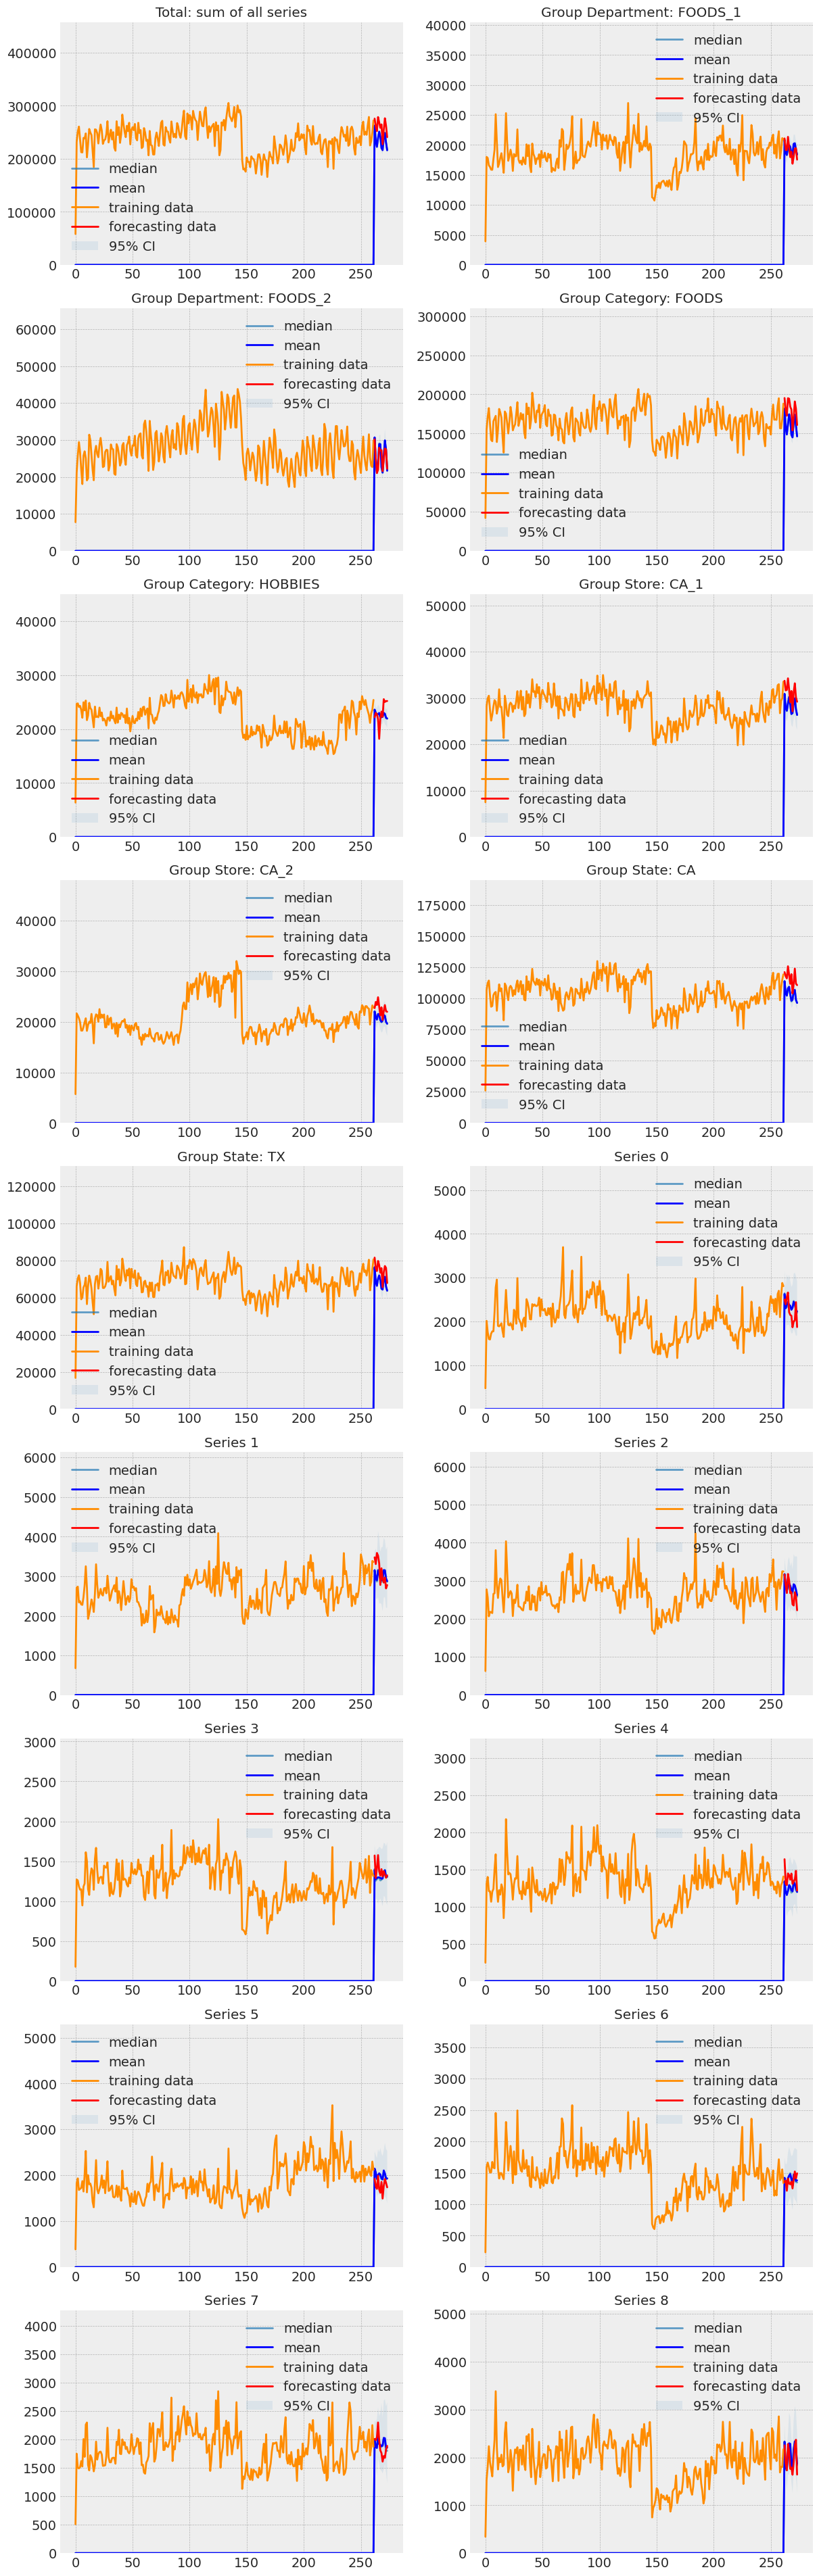

In [54]:
visualize_predict(groups, res, 10)

In [55]:
from sklearn.metrics import mean_squared_error

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.48,0.67,0.455,0.54,0.631,0.67,0.493
rmse,530.341,26800.489,4652.993,9656.929,2790.995,9060.047,2281.685


Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

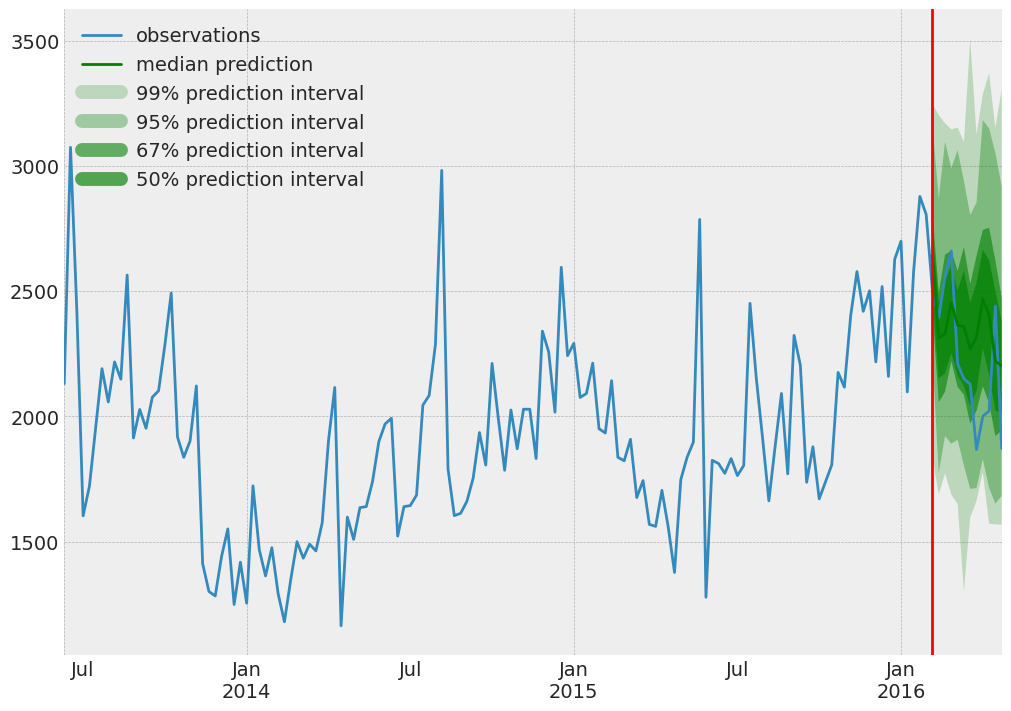

<Figure size 720x480 with 0 Axes>

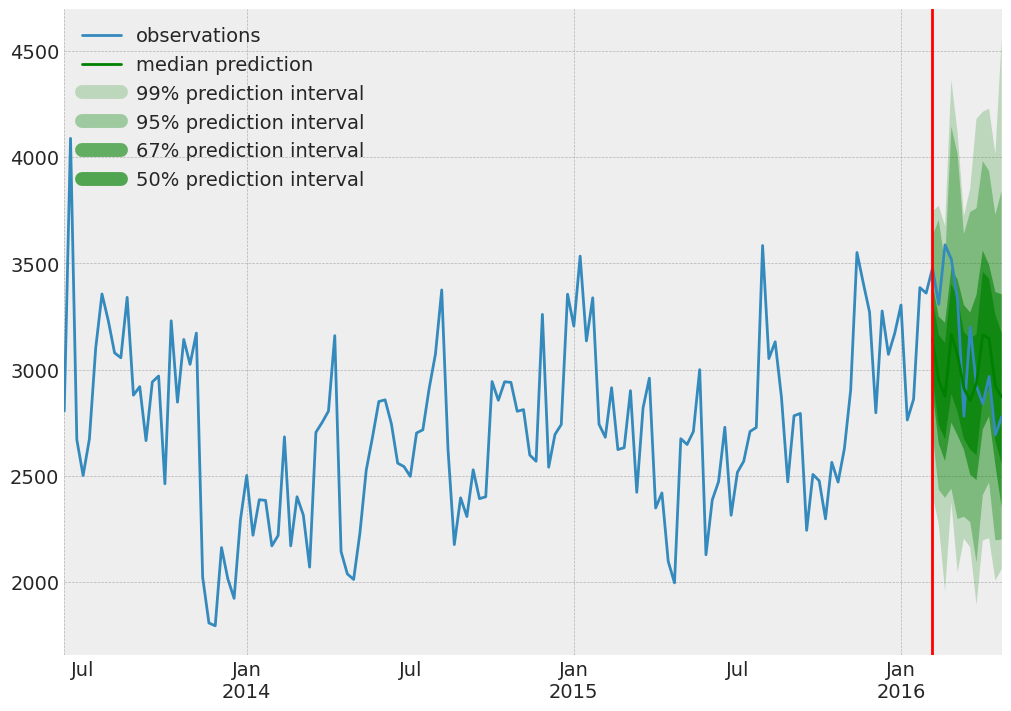

<Figure size 720x480 with 0 Axes>

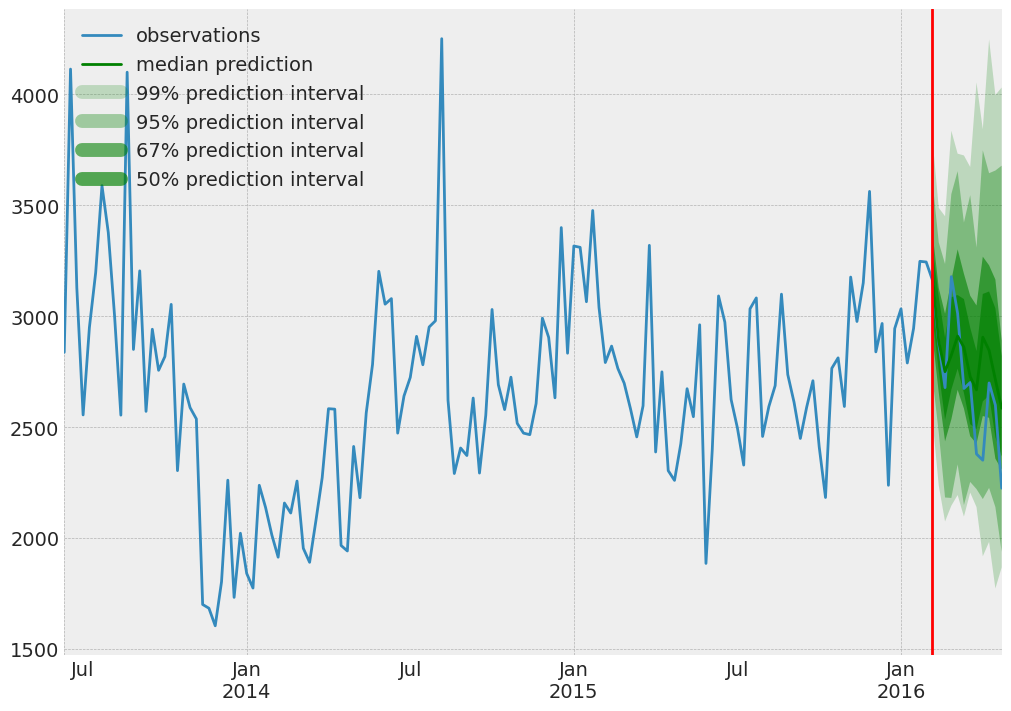

<Figure size 720x480 with 0 Axes>

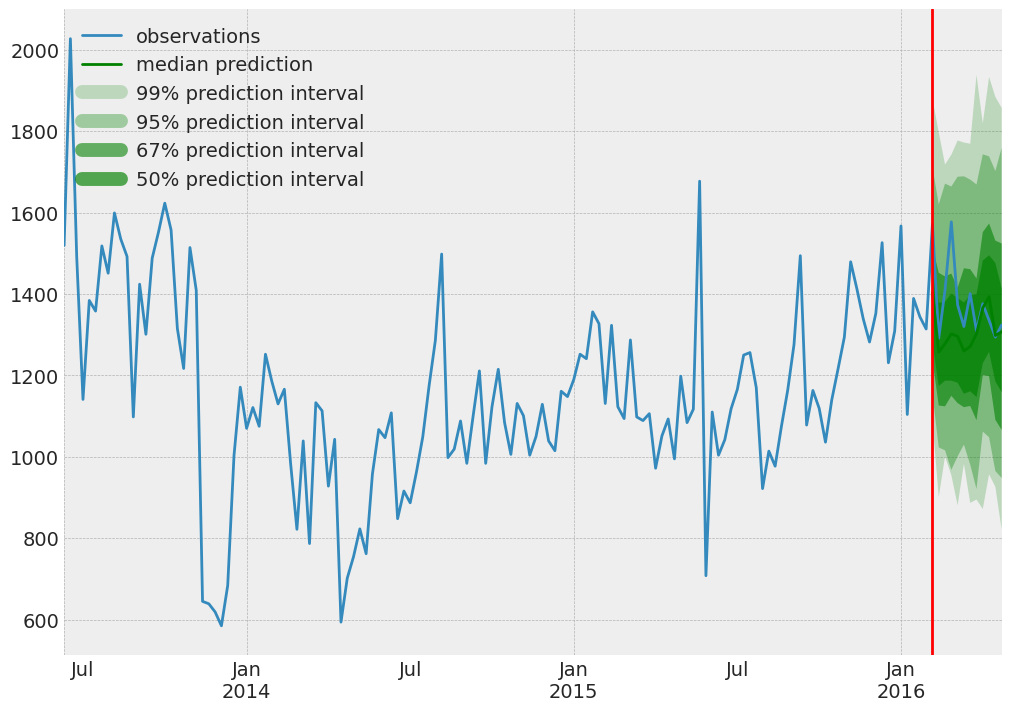

<Figure size 720x480 with 0 Axes>

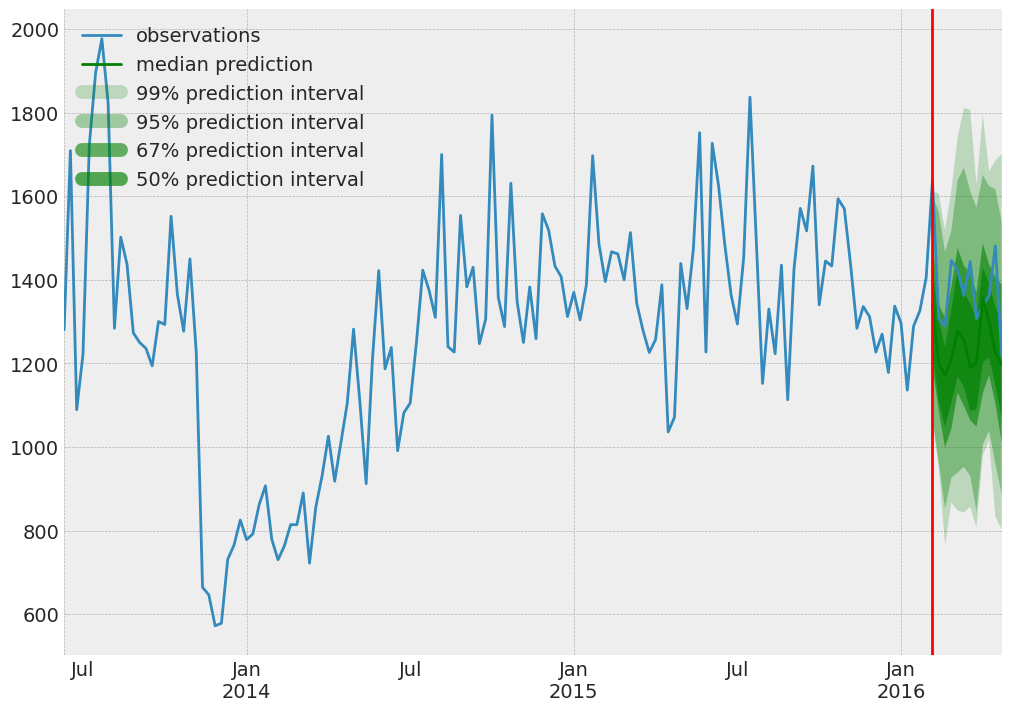

<Figure size 720x480 with 0 Axes>

In [56]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)
    